#  Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.

Требуется построить модель, которая по фотографии определит приблизительный возраст человека на основе набора фотографий людей с указанием возраста.

# 1. Исследовательский анализ данных

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Изучим данные. В выборке 7591 запись, колонки с названиями файлов и истинным возрастом.

In [4]:
# чтобы справиться с большим объёмом изображений используем динамическую загрузку данных
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


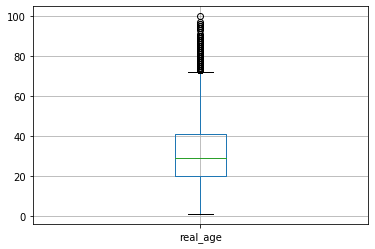

In [6]:
# смотрим распределение
labels.boxplot()

In [7]:
# Обработаем выбросы.
# IQR возьмем стандартные 1.5, будем полагать, что при возрасте старше 72.5 сложно определять зазличия в возрасте.
# нижнюю границу чуть расширим до 9 лет, предполагая, что более младшие дети в магазин не ходят одни в магазин, в принципе.
labels =  labels.loc[(labels['real_age'] <= 73) & (labels['real_age'] > 8)] 

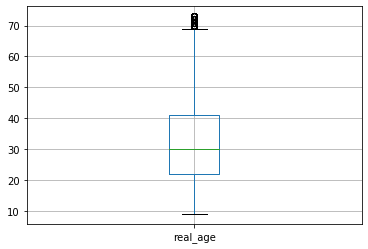

In [8]:
labels.boxplot()

In [9]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6803 entries, 1 to 7590
Data columns (total 2 columns):
file_name    6803 non-null object
real_age     6803 non-null int64
dtypes: int64(1), object(1)
memory usage: 159.4+ KB


Осталось 6803 записи.

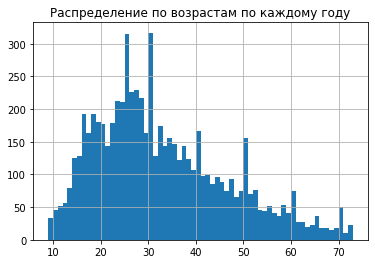

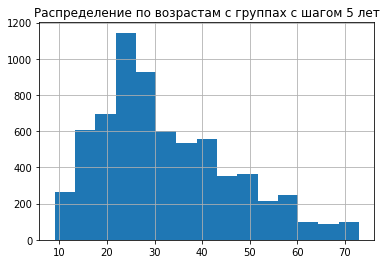

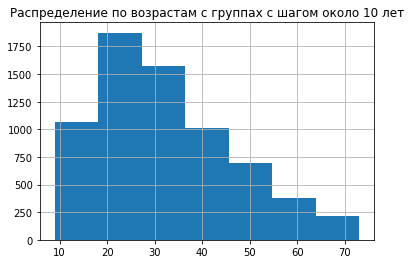

In [10]:
# для наглядности россмотрим распределение по возрастам для разных группировок
labels.hist(bins = 64)
plt.title('Распределение по возрастам по каждому году')
labels.hist(bins = 15)
plt.title('Распределение по возрастам с группах с шагом 5 лет')
labels.hist(bins = 7)
plt.title('Распределение по возрастам с группах с шагом около 10 лет')
plt.show()

По последнему графику можно сделать вывод, что максимальное количество в выборке людей имеют возраст 18-37 лет.

Возможно, это связано с привычным округлением до десятка при определении возраста (однако до 30 обычно проще возраст определяется, поэтому присутствует отдельный пик в 25 лет).

In [11]:
features, target = next(gen_flow)

In [12]:
print(features.shape)

(32, 224, 224, 3)


Получили признаки — четырёхмерный тензор, в котором 32 изображения размером 224x224 с тремя цветовыми каналами.

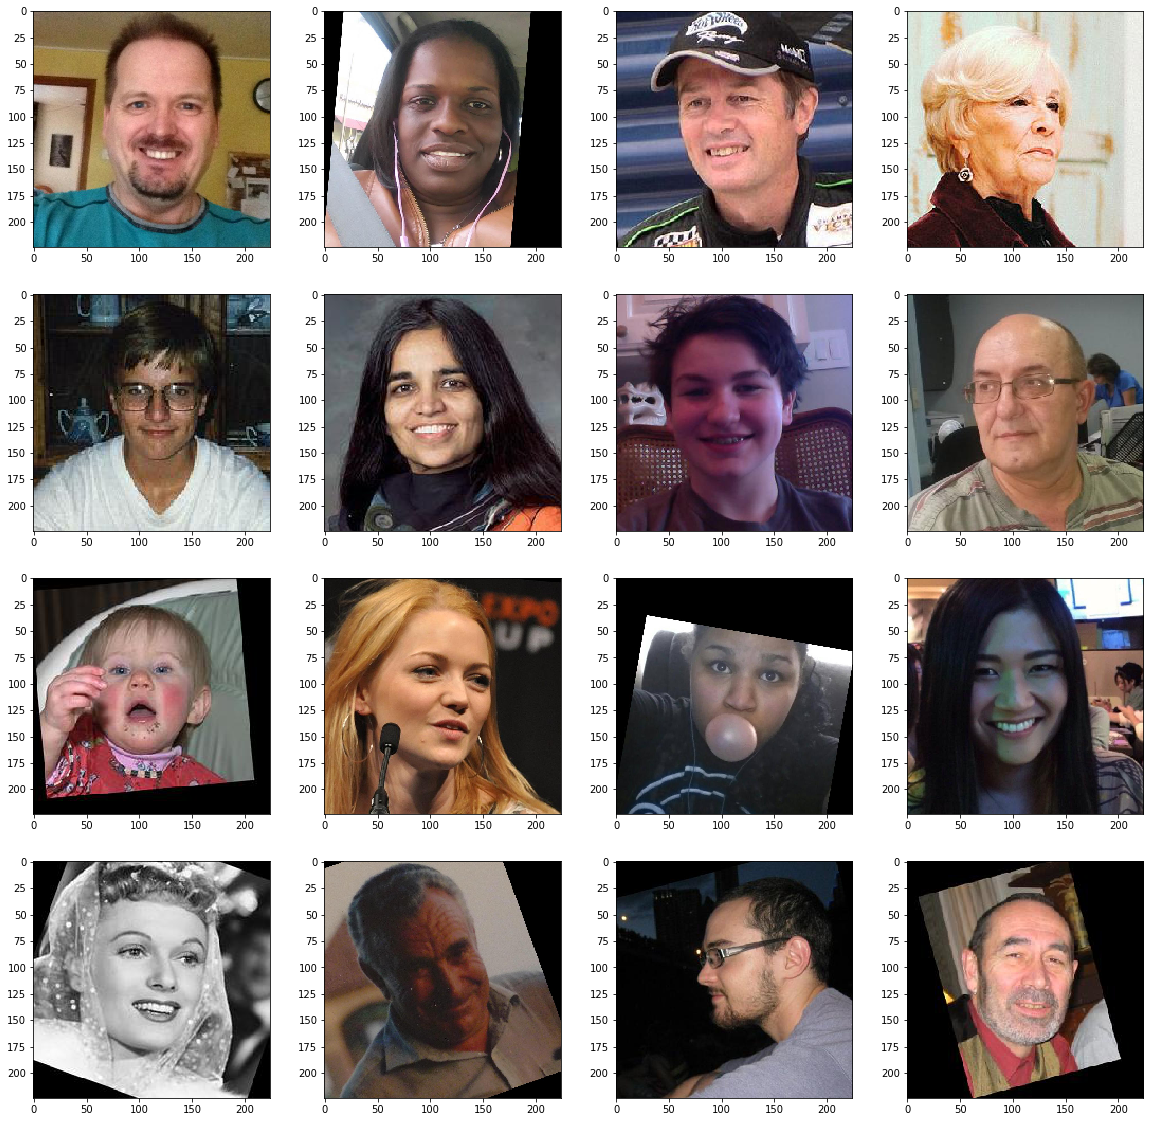

In [13]:
plt.figure(figsize=(20,20)) 

for i in range(16):
    plt.subplot(4,4,i+1)   
    plt.imshow(features[i])

plt.show()

# 2. Обучение модели

```python

# 
def load_train(path):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    labels = pd.read_csv(path + 'labels.csv')
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        subset='training',
        class_mode='raw', 
        seed=12345)

    return train_gen_flow

def load_test(path):
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    labels = pd.read_csv(path + 'labels.csv')
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        subset='validation',
        class_mode='raw',
        seed=12345)
 
    return test_gen_flow
 
def create_model(input_shape):
 
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
 
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=3,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model


```

```

# 2020-04-28 14:34:34.188286: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2020-04-28 14:34:34.190124: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2020-04-28 14:34:35.257547: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-04-28 14:34:35.926992: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2020-04-28 14:34:35.927102: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-04-28 14:34:35.927140: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-04-28 14:34:35.929258: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2020-04-28 14:34:35.929651: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2020-04-28 14:34:35.932269: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2020-04-28 14:34:35.933553: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2020-04-28 14:34:35.933610: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2020-04-28 14:34:35.937452: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2020-04-28 14:34:35.937805: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-04-28 14:34:35.945894: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999990000 Hz
2020-04-28 14:34:35.946615: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4dac400 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-04-28 14:34:35.946641: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-04-28 14:34:36.075564: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4e32420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2020-04-28 14:34:36.075609: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2020-04-28 14:34:36.077654: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2020-04-28 14:34:36.077711: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-04-28 14:34:36.077725: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-04-28 14:34:36.077749: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2020-04-28 14:34:36.077765: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2020-04-28 14:34:36.077779: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2020-04-28 14:34:36.077791: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2020-04-28 14:34:36.077801: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2020-04-28 14:34:36.081622: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2020-04-28 14:34:36.081723: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-04-28 14:34:36.414976: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2020-04-28 14:34:36.415052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2020-04-28 14:34:36.415063: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2020-04-28 14:34:36.419168: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/5
2020-04-28 14:34:48.700208: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-04-28 14:34:49.005886: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 52s - loss: 207.1340 - mae: 10.4161 - val_loss: 629.3030 - val_mae: 20.0230
Epoch 2/5
356/356 - 42s - loss: 70.7983 - mae: 6.4058 - val_loss: 128.2413 - val_mae: 8.6675
Epoch 3/5
356/356 - 42s - loss: 38.7025 - mae: 4.7681 - val_loss: 68.9075 - val_mae: 6.1349
Epoch 4/5
356/356 - 42s - loss: 24.1516 - mae: 3.7619 - val_loss: 135.7525 - val_mae: 9.4459
Epoch 5/5
356/356 - 42s - loss: 18.3385 - mae: 3.3182 - val_loss: 74.0968 - val_mae: 6.6472
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 74.0968 - mae: 6.6472


# 

```

# 3. Анализ обученной модели

В результате проделанной работы была построена модель, которая по фотографии определит приблизительный возраст человека со значение MAE = 6.6472 на валидационной выборке.

Модель была обучена на основе набора фотографий людей с указанием возраста с изначальным количеством 7591 фото, после обработки выбросов было использованно 6803 записи, максимальное количество в людей в датасете имеют возраст 18-37 лет.

Следует также отметить, что на графике распределения возраста по каждому году видим четкие пики на 25, 30, 40, 50, 60, 70 лет. Возможно, это связано с привычным округлением до десятка при определении возраста (однако до 30 обычно проще возраст определяется, поэтому присутствует отдельный пик в 25 лет).